# CNA ISD Investigation

Look at trends in the Integrated Surface Dataset (ISD Lite).

## Load ISD-Lite

For this analysis we only look at Texas and Oklahoma

In [19]:
import sys
import os
sys.path.append('../')
from setup import CWD, SCRATCH_DIR, DATA_DIR
print(CWD)
print(SCRATCH_DIR)

import polars as pl
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

isd_lite_metadata_file = os.path.join(DATA_DIR, 'isd_lite_cna_metadata.csv')
isd_lite_file = os.path.join(SCRATCH_DIR, 'isd_lite_cna.csv')

metadata = pl.read_csv(isd_lite_metadata_file)

# Remove some sites that have same USAF number but bad WBAN number
metadata = metadata.filter(
    # (pl.col('lon') <= -90) &
    # (pl.col('lon') >= -105) &
    # (pl.col('lat') <= 50) &
    # (pl.col('lat') >= 25) & 
    pl.col('ST').is_in(['TX', 'OK'])
)

isd_lite = pl.read_csv(
    isd_lite_file,
    try_parse_dates=True,
    schema_overrides={'windspeed': pl.Float32, 'winddirection': pl.Float32}
    )\
    .sort('time')\
    .filter(pl.col('USAF').is_in(metadata['USAF'].to_numpy()))\
    .filter(pl.col('time').dt.hour().is_in([0, 6, 12, 18])) # Many stations only record 4x a day

isd_lite

/home/valencig/GPLLJ/
/scratch/valencig/GPLLJ-Scratch/


time,USAF,windspeed,winddirection
datetime[μs],i64,f32,f32
1979-01-01 00:00:00,722420,7.2,360.0
1979-01-01 00:00:00,722508,3.0,110.0
1979-01-01 00:00:00,722437,6.1,360.0
1979-01-01 00:00:00,722415,2.5,290.0
1979-01-01 00:00:00,722545,6.6,360.0
…,…,…,…
2024-12-31 18:00:00,998490,8.8,350.0
2024-12-31 18:00:00,998481,4.1,30.0
2024-12-31 18:00:00,722561,6.2,340.0


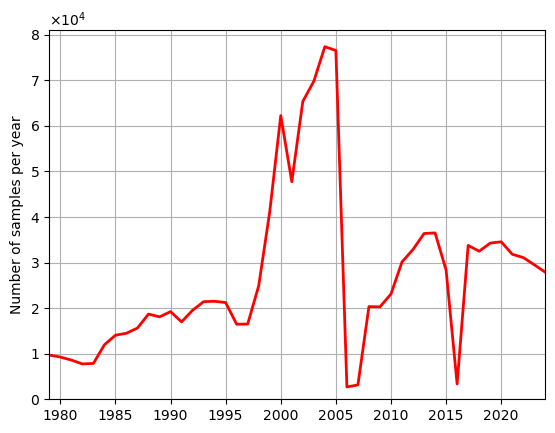

In [2]:
fig, ax1 = plt.subplots()
year_samples = isd_lite.group_by_dynamic('time', every='1y').agg(records=pl.col('windspeed').len())
ax1.plot(year_samples['time'], year_samples['records'], color='r', lw=2)
ax1.grid()
ax1.set_ylim(0, None)
ax1.set_xlim(year_samples['time'][0], year_samples['time'][-1])
ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax1.set_ylabel('Number of samples per year')
plt.show()

## Try to look at changes over time

A big issue is that the stations do not provide a consistent record. We are just looking at two states so we can try to isolate a few stations that have decent yearly measurements

7300.0
1980 # of good stations (n=5)
1990 # of good stations (n=9)
2000 # of good stations (n=21)
2010 # of good stations (n=22)


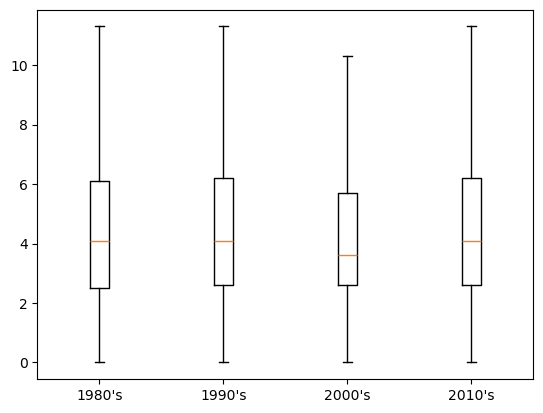

In [35]:
year_bins = [1980, 1990, 2000, 2010]
obs_threshold = 10 * 365 * 4 * 0.50 # Number of observations needed per bin
print(obs_threshold)
fig, ax = plt.subplots()
for i, start in enumerate(year_bins):
    end = start+9
    subset = isd_lite.filter(
        pl.col('time').is_between(datetime(start, 1, 1), datetime(end, 12, 31)),
    )
    # Wants stations that were active for > 50% of this timeframe
    obs_counts = subset.group_by('USAF').agg(counts=pl.col('windspeed').len())
    # Get stations with good counts
    good_stations = obs_counts.filter(pl.col('counts') >= obs_threshold)['USAF'].to_numpy()
    print(f'{start} # of good stations (n={len(good_stations)})')
    # Good data
    good_data = subset.filter(pl.col('USAF').is_in(good_stations))
    ax.boxplot(good_data['windspeed'], positions=[i], tick_labels=[f'{start}\'s'], showfliers=False)
plt.show()

(array([79.,  5.,  5.,  5., 15., 16., 19., 17., 28., 21.]),
 array([2.50000e-01, 3.63750e+01, 7.25000e+01, 1.08625e+02, 1.44750e+02,
        1.80875e+02, 2.17000e+02, 2.53125e+02, 2.89250e+02, 3.25375e+02,
        3.61500e+02]),
 <BarContainer object of 10 artists>)

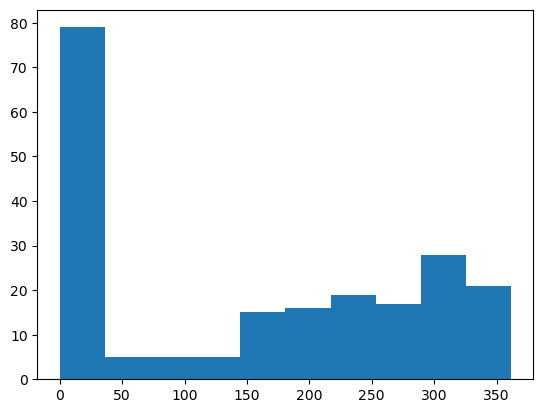

In [16]:
yearly_records = isd_lite.group_by_dynamic('time', every='1y', group_by='USAF').agg(days_of_record=pl.col('windspeed').len()/4)
mean_operational_days = yearly_records.group_by('USAF').agg(pl.col('days_of_record').mean())
plt.hist(mean_operational_days['days_of_record'])

## Come up with some scheme to merge spotty data

## Create dataframe of stations with consistent data

In [ ]:
# From 01-01-1979 till 12-31-2024
total_days = 16802

# Many stations only record 4 times a day
df_4xdaily = isd_lite.filter(pl.col('time').dt.hour().is_in([0, 6, 12, 18]))

# Ensure that each month has at least 14 days of data
num_obs = df_4xdaily.group_by_dynamic('time', every='1mo', group_by='USAF').agg(n_obs=pl.col('windspeed').count())

# Good months
valid_months = num_obs.filter(pl.col('n_obs') >= 14*4).group_by('USAF').agg(months=pl.col('USAF').len()).sort('months')

# Want >95% of the record to be good
num_months = (2024-1979)*12

#df_monthly = df_4xdaily.group_by_dynamic('time', every='1d', group_by='USAF').agg(windspeed=pl.col('windspeed').mean()).sort('time')

## Map of ISD-Lite Locations

In [ ]:
def add_latlon(ax):
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True, which='both',
        linewidth=1, color='k', alpha=1, linestyle='--'
    )
    gl.right_labels = None
    gl.top_labels = None
    gl.xlines = None
    gl.ylines = None
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # Increase the ticksize
    gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
    gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}

In [ ]:
# From 01-01-1979 till 12-31-2024
total_days = 16802

# Many stations only record 4 times a day
df_4xday = isd_lite.filter(pl.col('time').dt.hour().is_in([0, 6, 12, 18]))
df_daily = df_4xday.group_by_dynamic('time', every='1d', group_by='USAF').agg(windspeed=pl.col('windspeed').mean()).sort('time')

num_obs = df_daily.group_by(pl.col('USAF')).agg(operational_frac=pl.col('time').len()/total_days*100)\
    #.filter(pl.col('operational_frac') >= 80)
# Get USAF number of good stations
good_stations = num_obs['USAF'].to_numpy() # Gets rid of annoying warning

# Join reduced with metadata (duplicate stations in metadata are fine because lat lon is the same)
df_obs = num_obs.join(metadata, how='left', on='USAF').sort('USAF') # ensure ordering
print(df_obs)

year_samples = df_daily.filter(pl.col('USAF').is_in(good_stations)).group_by_dynamic('time', every='1y').agg(records=pl.col('USAF').len())
print(year_samples)

In [ ]:
fig = plt.figure(figsize=(10, 6))

gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.3, hspace=0.3)

# Plot 1: locations of all the sites
ax0 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
lat, lon = df_obs['lat'], df_obs['lon']
pts = ax0.scatter(lon, lat, c=df_obs['operational_frac'], transform=ccrs.PlateCarree(), vmin=0, vmax=100, cmap='plasma')
cbar = plt.colorbar(pts, ax=ax0, shrink=0.7, location='bottom')
cbar.set_label('foo')
ax0.add_feature(cfeature.STATES, linewidth=0.4)
ax0.add_feature(cfeature.COASTLINE, linewidth=1)
add_latlon(ax0)

# Plot 2: observations over time
ax1 = fig.add_subplot(gs[1])
ax1.plot(year_samples['time'], year_samples['records'], color='r', lw=2)
ax1.grid()
ax1.set_ylim(0, None)
ax1.set_xlim(year_samples['time'][0], year_samples['time'][-1])
ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# Labels
ax0.set_title(f'(a) Locations of ISD Lite Stations (n={len(df_obs)})')
ax1.set_title(f'(b) Number of total wind speed observations per year')
plt.show()

## Create dataframe with just these good stations

In [ ]:
df_reduced = df_daily.filter(pl.col('USAF').is_in(good_stations))

In [ ]:
fig, ax = plt.subplots()
total = df_reduced.group_by_dynamic('time', every='1y').agg(
    windspeed = pl.col('windspeed').mean(),
    windspeed_05 = pl.col('windspeed').quantile(0.05),
    windspeed_95 = pl.col('windspeed').quantile(0.95),
    stderr = pl.col('windspeed').std() / np.sqrt(pl.col('USAF').unique().len())
)
x = total['time']
y = total['windspeed']
ax.plot(x, y, color='r', lw=2)
ax.fill_between(x, y+total['stderr'], y-total['stderr'], color='r', alpha=0.3)
ax.set_xlim(x[0], x[-1])
# for thresh in [5, 10, 20, 30, 40, 50, 70, 90]:
#     subset_usaf = num_obs.filter(pl.col('operational_frac') >= thresh)['USAF'].to_numpy()
#     subset = isd_lite.filter(pl.col('USAF').is_in(subset_usaf))
#     mean_wind = subset.group_by_dynamic('time', every='1y').agg(
#         windspeed = pl.col('windspeed').mean(),
#     )['windspeed']
#     ax.plot(x, mean_wind/mean_wind[0]-1, label=f'{thresh} % (n={len(subset_usaf)})')
#ax.hlines(0, x[0], x[-1], color='k', linestyle='dotted')
#ax.legend()
plt.show()

## Histogram